# Training SpeechT5 on VoxPopuli dataset (with already prepared dataset)
## Based on the following [tutorial](https://huggingface.co/learn/audio-course/chapter6/fine-tuning). With any questions please refer to README.md and the tutorial above.

Make sure to run the softstack.ipynb file first to install all necessary dependencies.


## GPU Check

In [ ]:
!nvidia-smi

## Logging into Hugging Face
Use [huggingface-cli](https://huggingface.co/docs/huggingface_hub/guides/cli) to login to your account.


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

## Loading the dataset

In [ ]:
from datasets import load_dataset, Audio

dataset = load_dataset("facebook/voxpopuli", "pl", split="train")
len(dataset)

In [5]:
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))

## Defining model checkpoint and processor
#### Because SpeechT5 was trained on the English language, it may not recognize certain characters in the Polish dataset.
#### SpeechT5 tokenizer doesn’t have any tokens for numbers, it'd be good to have a normalized text for this case (e.g. "jeden" instead of "1").
#### In order to preserve the meaning of the text, we can replace polish characters with regular ones (e.g. "ą" with "a").


In [6]:
from transformers import SpeechT5Processor

checkpoint = "microsoft/speecht5_tts"
processor = SpeechT5Processor.from_pretrained(checkpoint)

## Text cleanup for SpeechT5 tokenization

In [7]:
tokenizer = processor.tokenizer

In [ ]:
dataset[0]

In [ ]:
def extract_all_chars(batch):
    all_text = " ".join(batch["normalized_text"])
    vocab = list(set(all_text))
    return {"vocab": [vocab], "all_text": [all_text]}


vocabs = dataset.map(
    extract_all_chars,
    batched=True,
    batch_size=-1,
    keep_in_memory=True,
    remove_columns=dataset.column_names,
)

dataset_vocab = set(vocabs["vocab"][0])
tokenizer_vocab = {k for k, _ in tokenizer.get_vocab().items()}

In [ ]:
dataset_vocab - tokenizer_vocab

In [11]:
replacements = [
    ("ą", "a"),
    ("ó", "o"),
    ("ć", "c"),
    ("ę", "e"),
    ("ł", "l"),
    ("ń", "n"),
    ("ś", "s"),
    ("ż", "z"),
    ("ź", "z"),
]


def cleanup_text(inputs):
    for src, dst in replacements:
        inputs["normalized_text"] = inputs["normalized_text"].replace(src, dst)
    return inputs


dataset = dataset.map(cleanup_text)

In [12]:
from collections import defaultdict

speaker_counts = defaultdict(int)

for speaker_id in dataset["speaker_id"]:
    speaker_counts[speaker_id] += 1

In [13]:
def select_speaker(speaker_id):
    return 100 <= speaker_counts[speaker_id] <= 400


dataset = dataset.filter(select_speaker, input_columns=["speaker_id"])

In [ ]:
len(set(dataset["speaker_id"]))

In [ ]:
len(dataset)

 ## Creating a speaker embedding for each example.

In [ ]:
import os
import torch
from speechbrain.pretrained import EncoderClassifier

spk_model_name = "speechbrain/spkrec-xvect-voxceleb"

device = "cuda" if torch.cuda.is_available() else "cpu"
speaker_model = EncoderClassifier.from_hparams(
    source=spk_model_name,
    run_opts={"device": device},
    savedir=os.path.join("/tmp", spk_model_name),
)


def create_speaker_embedding(waveform):
    with torch.no_grad():
        speaker_embeddings = speaker_model.encode_batch(torch.tensor(waveform))
        speaker_embeddings = torch.nn.functional.normalize(speaker_embeddings, dim=2)
        speaker_embeddings = speaker_embeddings.squeeze().cpu().numpy()
    return speaker_embeddings

#### speechbrain/spkrec-xvect-voxceleb model was trained on English speech from the VoxCeleb dataset, whereas the training examples in this guide are in Polish. While we believe that this model will still generate reasonable speaker embeddings for our Polish dataset, this assumption may not hold true in all cases.

## Processing the dataset
### SpeechT5Processor tokenizes the input text and loads the target audio into a log-mel spectrogram. It should also add the speaker embeddings as an additional input

In [17]:
def prepare_dataset(example):
    audio = example["audio"]

    example = processor(
        text=example["normalized_text"],
        audio_target=audio["array"],
        sampling_rate=audio["sampling_rate"],
        return_attention_mask=False,
    )

    # strip off the batch dimension
    example["labels"] = example["labels"][0]

    # use SpeechBrain to obtain x-vector
    example["speaker_embeddings"] = create_speaker_embedding(audio["array"])

    return example

In [ ]:
processed_example = prepare_dataset(dataset[0])
list(processed_example.keys())

In [19]:
processed_example["speaker_embeddings"].shape

(512,)

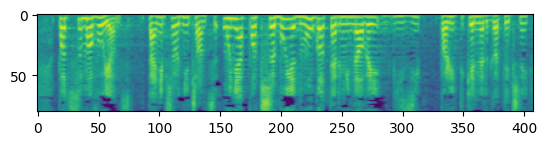

In [20]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(processed_example["labels"].T)
plt.show()

## Applying the processing function to the entire dataset. This might take a while

In [21]:
dataset = dataset.map(prepare_dataset, remove_columns=dataset.column_names)

In [ ]:
def is_not_too_long(input_ids):
    input_length = len(input_ids)
    return input_length < 200


dataset = dataset.filter(is_not_too_long, input_columns=["input_ids"])
len(dataset)

## Create a basic train/test split:

In [23]:
dataset = dataset.train_test_split(test_size=0.1)

## Data collator
### In order to combine multiple examples into a batch, you need to define a custom data collator.

In [24]:
from dataclasses import dataclass
from typing import Any, Dict, List, Union



class TTSDataCollatorWithPadding:
    processor: Any

    def __call__(
        self, features: List[Dict[str, Union[List[int], torch.Tensor]]]
    ) -> Dict[str, torch.Tensor]:
        input_ids = [{"input_ids": feature["input_ids"]} for feature in features]
        label_features = [{"input_values": feature["labels"]} for feature in features]
        speaker_features = [feature["speaker_embeddings"] for feature in features]

        # collate the inputs and targets into a batch
        batch = processor.pad(
            input_ids=input_ids, labels=label_features, return_tensors="pt"
        )

        # replace padding with -100 to ignore loss correctly
        batch["labels"] = batch["labels"].masked_fill(
            batch.decoder_attention_mask.unsqueeze(-1).ne(1), -100
        )

        # not used during fine-tuning
        del batch["decoder_attention_mask"]

        # round down target lengths to multiple of reduction factor
        if model.config.reduction_factor > 1:
            target_lengths = torch.tensor(
                [len(feature["input_values"]) for feature in label_features]
            )
            target_lengths = target_lengths.new(
                [
                    length - length % model.config.reduction_factor
                    for length in target_lengths
                ]
            )
            max_length = max(target_lengths)
            batch["labels"] = batch["labels"][:, :max_length]

        # also add in the speaker embeddings
        batch["speaker_embeddings"] = torch.tensor(speaker_features)

        return batch

In [25]:
data_collator = TTSDataCollatorWithPadding()

## Training the model

In [26]:
from transformers import SpeechT5ForTextToSpeech

model = SpeechT5ForTextToSpeech.from_pretrained(checkpoint)

In [27]:
from functools import partial

# disable cache during training since it's incompatible with gradient checkpointing
model.config.use_cache = False

# set language and task for generation and re-enable cache
model.generate = partial(model.generate, use_cache=True)

In [28]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="",  # change to a repo name of your choice
    per_device_train_batch_size=4,
    gradient_accumulation_steps=8,
    learning_rate=1e-5,
    warmup_steps=500,
    max_steps=4000,
    gradient_checkpointing=True,
    fp16=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=2,
    save_steps=1000,
    eval_steps=1000,
    logging_steps=25,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    greater_is_better=False,
    label_names=["labels"],
    push_to_hub=False,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    data_collator=data_collator,
    tokenizer=processor,
)

In [ ]:
trainer.train()

In [ ]:
trainer.push_to_hub()

## Generacja Audio

In [30]:
from transformers import SpeechT5ForTextToSpeech

In [31]:
model = SpeechT5ForTextToSpeech.from_pretrained(
    "speecht5_finetuned_voxpopuli_pl/",
)

In [32]:
example = dataset["test"][304]
speaker_embeddings = torch.tensor(example["speaker_embeddings"]).unsqueeze(0)

In [37]:
text = "Siema! Test modelu wytrenowanego na polski. To jest przykładowe długie zdanie"

In [38]:
inputs = processor(text=text, return_tensors="pt")

In [39]:
from transformers import SpeechT5HifiGan

vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")
speech = model.generate_speech(inputs["input_ids"], speaker_embeddings, vocoder=vocoder)

In [ ]:
from IPython.display import Audio

Audio(speech.numpy(), rate=16000)